<a href="https://colab.research.google.com/github/AndrewArnett/BuildWeek2/blob/master/Build_Week_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importing, Exploring, and Cleaning Data

In [1]:
!pip install pandas-profiling==2.*
!pip install category_encoders==2.*
!pip install eli5

In [220]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from category_encoders import OneHotEncoder

In [221]:
import pandas as pd

df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00468/online_shoppers_intention.csv')

In [222]:
from pandas_profiling import ProfileReport

profile = ProfileReport(df, minimal=True).to_notebook_iframe()

profile

In [223]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


### Data Cleaning/Modeling

In [224]:
df1 = df.copy()
df1['Returning'] = df1['VisitorType'] == 'Returning_Visitor'
df1['Gift'] = (df1['SpecialDay']>=0.6) & (df1['Returning']==True)
df1 = df1.drop('Returning', axis=1)
df1.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,False


In [225]:
y = df1['Revenue']
X = df1.drop('Revenue', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

### Baseline

In [226]:
y_train.value_counts(normalize=True)

False    0.845296
True     0.154704
Name: Revenue, dtype: float64

### Logistic Model Without SMOTE

In [227]:
log_model1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

log_model1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [228]:
print('Training Accuracy:', log_model1.score(X_train, y_train))
print('Validation Accuracy:', log_model1.score(X_val, y_val))

Training Accuracy: 0.8855433901054339
Validation Accuracy: 0.8811841038118411


In [229]:
log_predict = log_model1.predict(X_val)
pd.crosstab(y_val, log_predict)

col_0,False,True
Revenue,,
False,2028,56
True,237,145


In [230]:
print(classification_report(y_val, log_predict))

              precision    recall  f1-score   support

       False       0.90      0.97      0.93      2084
        True       0.72      0.38      0.50       382

    accuracy                           0.88      2466
   macro avg       0.81      0.68      0.72      2466
weighted avg       0.87      0.88      0.87      2466



In [231]:
log_pred_prob = log_model1.predict_proba(X_val)[:, -1]

fpr3, tpr3, thresholds3 = roc_curve(y_val, log_pred_prob)

tpr_fpr_thresh3 = pd.DataFrame({'False Positive Rate': fpr3,
                    'True Positive Rate': tpr3,
                    'Threshold': np.round(thresholds3, 2)})

a = print('Logistic Regression without SMOTE:', roc_auc_score(y_val, log_pred_prob))
tpr_fpr_thresh3

Logistic Regression without SMOTE: 0.8956082744621199


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.0
1,0.000000,0.002618,1.0
2,0.000000,0.013089,1.0
3,0.000480,0.013089,1.0
4,0.000480,0.018325,1.0
...,...,...,...
413,0.986084,1.000000,0.0
414,0.987044,1.000000,0.0
415,0.988004,1.000000,0.0
416,0.988964,1.000000,0.0


Text(0, 0.5, 'True Positive Rate')

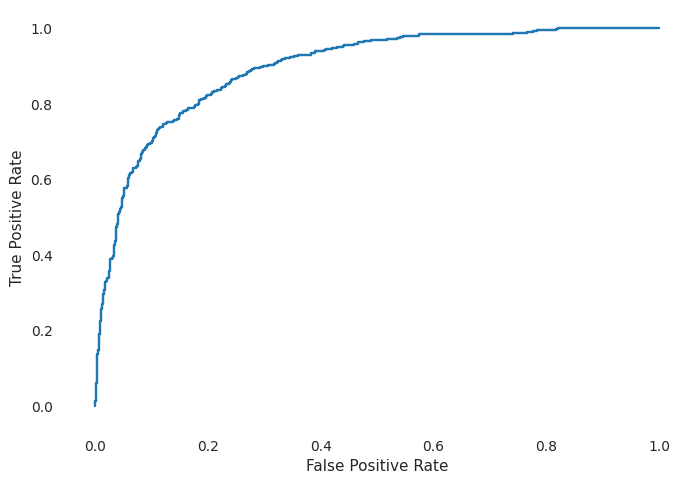

In [232]:
plt.plot(fpr3, tpr3)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Random Forest Classifier Model Without SMOTE

In [233]:
model = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, criterion='entropy', min_samples_leaf=2, 
                           random_state=23)
)

model.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split

In [234]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9796228710462287
Validation Accuracy: 0.8998377939983779


In [235]:
y_predict = model.predict(X_val)
pd.crosstab(y_val, y_predict)

col_0,False,True
Revenue,,
False,2001,83
True,164,218


In [236]:
print(classification_report(y_val, y_predict))

              precision    recall  f1-score   support

       False       0.92      0.96      0.94      2084
        True       0.72      0.57      0.64       382

    accuracy                           0.90      2466
   macro avg       0.82      0.77      0.79      2466
weighted avg       0.89      0.90      0.89      2466



In [237]:
y_pred_prob = model.predict_proba(X_val)[:, -1]

fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

tpr_fpr_thresh = pd.DataFrame({'False Positive Rate': fpr,
                    'True Positive Rate': tpr,
                    'Threshold': np.round(thresholds, 2)})

b = print('Random Forest Classifier without SMOTE:', roc_auc_score(y_val, y_pred_prob))
tpr_fpr_thresh

Random Forest Classifier without SMOTE: 0.9335412667946257


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.97
1,0.000000,0.002618,0.97
2,0.000000,0.125654,0.85
3,0.000480,0.125654,0.85
4,0.000480,0.130890,0.85
...,...,...,...
398,0.952975,1.000000,0.00
399,0.953455,1.000000,0.00
400,0.967850,1.000000,0.00
401,0.968330,1.000000,0.00


Text(0, 0.5, 'True Positive Rate')

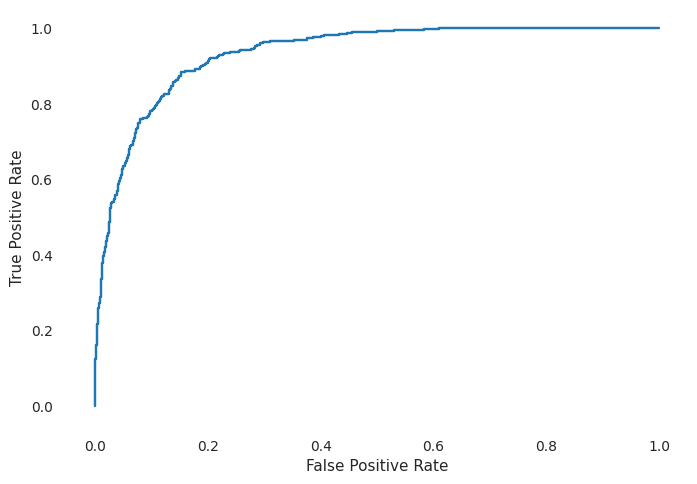

In [238]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

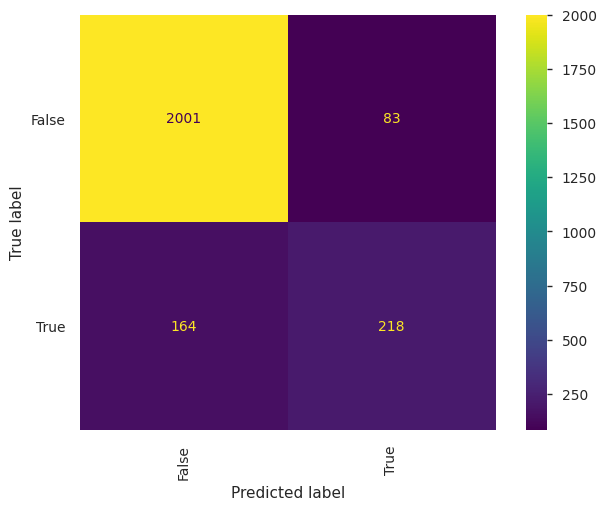

In [239]:
plt.rcParams['figure.dpi'] = 100
plot_confusion_matrix(model, X_val, y_val, values_format='.0f', xticks_rotation='vertical');

In [240]:
ok = model.named_steps['randomforestclassifier'].feature_importances_

encoder = model.named_steps['onehotencoder']
encoded_columns = encoder.transform(X_val).columns

importance = pd.DataFrame({'encoded_columns':encoded_columns,'feature_importances':ok})
importance.sort_values('feature_importances', ascending=False)

,encoded_columns,feature_importances
8,PageValues,0.371428
7,ExitRates,0.089678
5,ProductRelated_Duration,0.083789
4,ProductRelated,0.071580
6,BounceRates,0.054859
1,Administrative_Duration,0.053785
0,Administrative,0.041511
23,TrafficType,0.029270
14,Month_Nov,0.029038
22,Region,0.028770


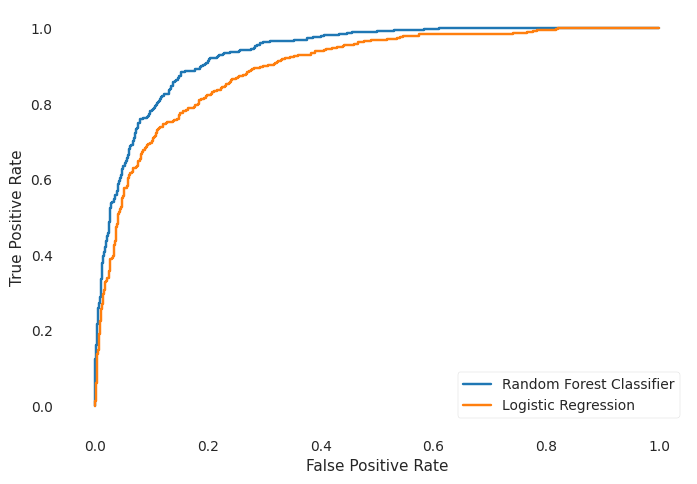

In [241]:
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.plot(fpr3, tpr3, label='Logistic Regression')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [242]:
print('Validation Accuracy of Logistic Regression:', log_model1.score(X_val, y_val))
print('Validation Accuracy of Random Forest Classifier:', model.score(X_val, y_val))

Validation Accuracy of Logistic Regression: 0.8811841038118411
Validation Accuracy of Random Forest Classifier: 0.8998377939983779


In [243]:
operating_systems = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h'}
region = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i'}
browser = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 
           11:'k', 12:'l', 13:'m'}
traffic_type = {1:'a', 2:'b', 3:'c', 4:'d', 5:'e', 6:'f', 7:'g', 8:'h', 9:'i', 10:'j', 
           11:'k', 12:'l', 13:'m', 14:'n', 15:'o', 16:'p', 17:'q', 18:'r', 19:'s', 20:'t'}

In [244]:
df2 = df1.copy()
df2 = df2.replace({"Region": region, "Browser": browser, "OperatingSystems": operating_systems, "TrafficType": traffic_type})
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,a,a,a,a,Returning_Visitor,False,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,b,b,a,b,Returning_Visitor,False,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,d,a,i,c,Returning_Visitor,False,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,c,b,b,d,Returning_Visitor,False,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,c,c,a,d,Returning_Visitor,True,False,False


In [245]:
columns = ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'Month', 
           'VisitorType', 'Weekend', 'Gift']

In [246]:
def encode_onehot(df, cols):
  vec = DictVectorizer()
  
  vec_data = pd.DataFrame(vec.fit_transform(df[cols].to_dict(orient='records')).toarray())
  vec_data.columns = vec.get_feature_names()
  vec_data.index = df.index

  df = df.drop(cols, axis=1)
  df = df.join(vec_data)
  return df



In [247]:
df2 = encode_onehot(df2, cols=columns)

In [248]:
df2.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Revenue,Browser=a,Browser=b,Browser=c,Browser=d,Browser=e,Browser=f,Browser=g,Browser=h,Browser=i,Browser=j,Browser=k,Browser=l,Browser=m,Gift,Month=Aug,Month=Dec,Month=Feb,Month=Jul,Month=June,Month=Mar,Month=May,Month=Nov,Month=Oct,Month=Sep,OperatingSystems=a,OperatingSystems=b,OperatingSystems=c,OperatingSystems=d,OperatingSystems=e,OperatingSystems=f,OperatingSystems=g,OperatingSystems=h,Region=a,Region=b,Region=c,Region=d,Region=e,Region=f,Region=g,Region=h,Region=i,TrafficType=a,TrafficType=b,TrafficType=c,TrafficType=d,TrafficType=e,TrafficType=f,TrafficType=g,TrafficType=h,TrafficType=i,TrafficType=j,TrafficType=k,TrafficType=l,TrafficType=m,TrafficType=n,TrafficType=o,TrafficType=p,TrafficType=q,TrafficType=r,TrafficType=s,TrafficType=t,VisitorType=New_Visitor,VisitorType=Other,VisitorType=Returning_Visitor,Weekend
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,False,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,False,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0


In [249]:
y = df2['Revenue']
X = df2.drop('Revenue', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

In [250]:
import eli5
from eli5.sklearn import PermutationImportance

transformers = make_pipeline(
    #OneHotEncoder(),
    StandardScaler()
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model_show = RandomForestClassifier()
model_show.fit(X_train_transformed, y_train)

feature_names = X_val.columns.tolist()

permuter = PermutationImportance(
    model_show,
    scoring='accuracy',
    n_iter=5,
    random_state=23
)

permuter.fit(X_val_transformed, y_val)

eli5.show_weights(
    permuter,
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.0994 ± 0.0085,PageValues
0.0043 ± 0.0038,Month=Nov
0.0030 ± 0.0032,BounceRates
0.0029 ± 0.0056,ExitRates
0.0018 ± 0.0039,ProductRelated
0.0006 ± 0.0015,Month=Dec
0.0006 ± 0.0006,Month=Oct
0.0006 ± 0.0014,TrafficType=c
0.0006 ± 0.0006,Region=c
0.0004 ± 0.0005,Region=e


In [251]:
smt = SMOTE()

X_train_smt, y_train_smt = smt.fit_sample(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


### Logistic Regression Model With SMOTE

In [252]:
log_model = make_pipeline(
    StandardScaler(),
    LogisticRegression()
)

log_model.fit(X_train_smt, y_train_smt)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [253]:
print('Training Accuracy:', log_model.score(X_train_smt, y_train_smt))
print('Validation Accuracy:', log_model.score(X_val, y_val))

Training Accuracy: 0.8359918445670425
Validation Accuracy: 0.8450932684509327


In [254]:
y1_predict = log_model.predict(X_val)
pd.crosstab(y_val, y1_predict)

col_0,False,True
Revenue,,
False,1783,301
True,81,301


In [255]:
print(classification_report(y_val, y1_predict))

              precision    recall  f1-score   support

       False       0.96      0.86      0.90      2084
        True       0.50      0.79      0.61       382

    accuracy                           0.85      2466
   macro avg       0.73      0.82      0.76      2466
weighted avg       0.89      0.85      0.86      2466



In [256]:
y_pred_prob1 = log_model.predict_proba(X_val)[:, -1]

fpr1, tpr1, thresholds1 = roc_curve(y_val, y_pred_prob1)

tpr_fpr_thresh1 = pd.DataFrame({'False Positive Rate': fpr1,
                    'True Positive Rate': tpr1,
                    'Threshold': np.round(thresholds1, 2)})

c = print('Logistic Regression with SMOTE:', roc_auc_score(y_val, y_pred_prob1))
tpr_fpr_thresh1

Logistic Regression with SMOTE: 0.9016088673613972


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,2.00
1,0.000000,0.005236,1.00
2,0.000000,0.015707,1.00
3,0.000960,0.015707,1.00
4,0.000960,0.034031,1.00
...,...,...,...
419,0.988484,1.000000,0.01
420,0.989443,1.000000,0.01
421,0.993762,1.000000,0.01
422,0.994722,1.000000,0.01


Text(0, 0.5, 'True Positive Rate')

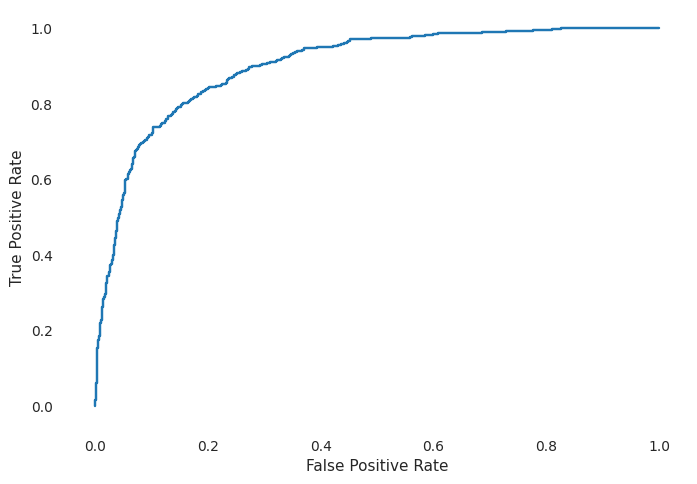

In [257]:
plt.plot(fpr1, tpr1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

### Random Forest Classifer Model With SMOTE

In [258]:
for_model = make_pipeline(
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, criterion='entropy', min_samples_leaf=2, 
                           random_state=23)
)

for_model.fit(X_train_smt, y_train_smt)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split=2,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=23,
                                        verbose=0, warm_start=False))],
         verbose=

In [259]:
print('Training Accuracy:', for_model.score(X_train_smt, y_train_smt))
print('Validation Accuracy:', for_model.score(X_val, y_val))

Training Accuracy: 0.9851283281362437
Validation Accuracy: 0.8986212489862125


In [260]:
y_for_predict = for_model.predict(X_val)
pd.crosstab(y_val, y_for_predict)

col_0,False,True
Revenue,,
False,1978,106
True,144,238


In [261]:
print(classification_report(y_val, y_for_predict))

              precision    recall  f1-score   support

       False       0.93      0.95      0.94      2084
        True       0.69      0.62      0.66       382

    accuracy                           0.90      2466
   macro avg       0.81      0.79      0.80      2466
weighted avg       0.89      0.90      0.90      2466



In [262]:
y_pred_prob2 = for_model.predict_proba(X_val)[:, -1]

fpr2, tpr2, thresholds2 = roc_curve(y_val, y_pred_prob2)

tpr_fpr_thresh2 = pd.DataFrame({'False Positive Rate': fpr2,
                    'True Positive Rate': tpr2,
                    'Threshold': np.round(thresholds2, 2)})
d = print('Random Forest Classifier with SMOTE:', roc_auc_score(y_val, y_pred_prob2))
tpr_fpr_thresh2

Random Forest Classifier with SMOTE: 0.930428545587925


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.95
1,0.000480,0.000000,0.95
2,0.000480,0.041885,0.86
3,0.000960,0.041885,0.86
4,0.000960,0.054974,0.85
...,...,...,...
375,0.994242,1.000000,0.00
376,0.995681,1.000000,0.00
377,0.996641,1.000000,0.00
378,0.998560,1.000000,0.00


Text(0, 0.5, 'True Positive Rate')

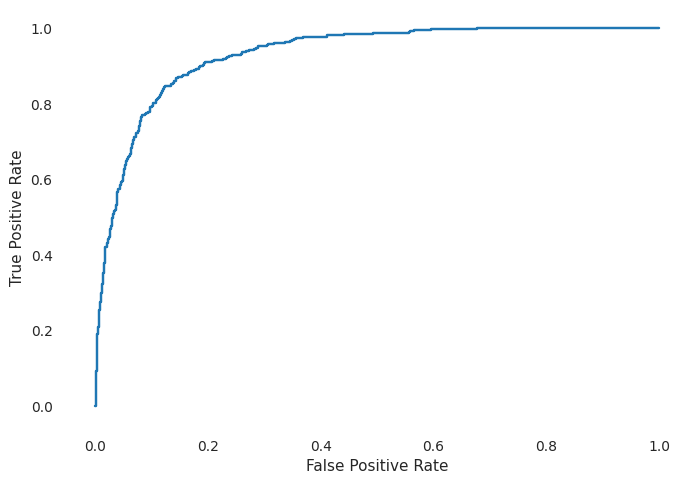

In [263]:
plt.plot(fpr2, tpr2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

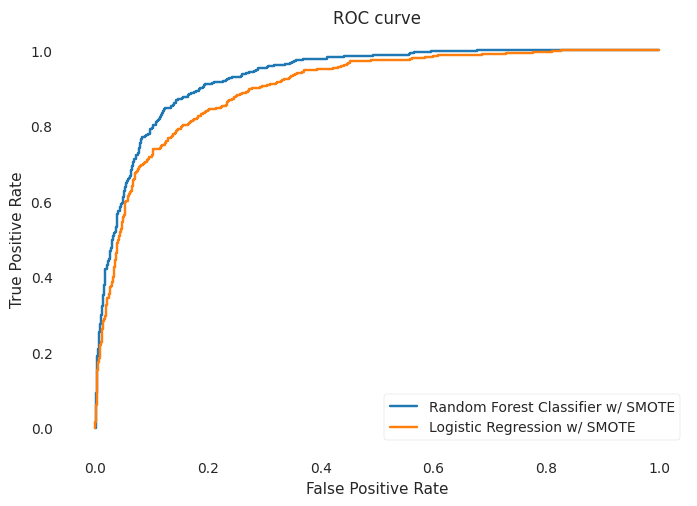

In [264]:
plt.plot(fpr2, tpr2, label='Random Forest Classifier w/ SMOTE')
plt.plot(fpr1, tpr1, label='Logistic Regression w/ SMOTE')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [265]:
print('Validation Accuracy of Logistic Regression w/ SMOTE:', log_model.score(X_val, y_val))
print('Validation Accuracy of Random Forest Classifier w/ SMOTE:', for_model.score(X_val, y_val))

Validation Accuracy of Logistic Regression w/ SMOTE: 0.8450932684509327
Validation Accuracy of Random Forest Classifier w/ SMOTE: 0.8986212489862125


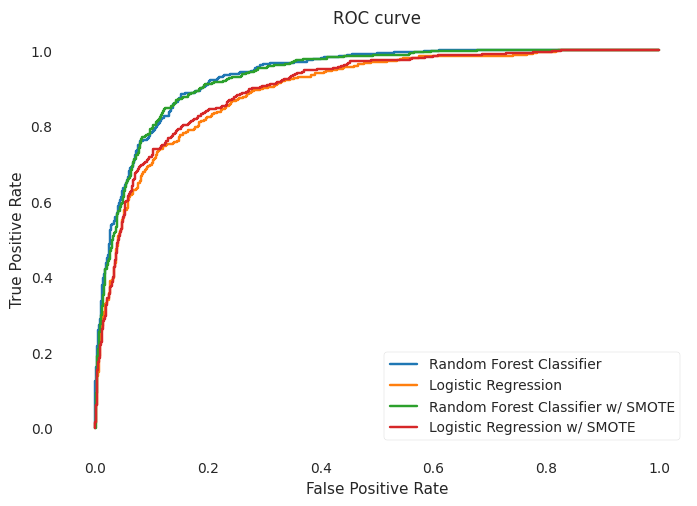

In [266]:
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.plot(fpr3, tpr3, label = 'Logistic Regression')
plt.plot(fpr2, tpr2, label='Random Forest Classifier w/ SMOTE')
plt.plot(fpr1, tpr1, label='Logistic Regression w/ SMOTE')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

### Parameter Tuning My Forest Models

In [14]:
### Heads up before you run, this will take a couple hours
param_grid = { 
    'randomforestclassifier__n_estimators': [500, 600],
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [8, 10, 12, None],
    'randomforestclassifier__criterion': ['gini', 'entropy'],
    'randomforestclassifier__min_samples_split': [1, 2, 3, 5],
    'randomforestclassifier__min_samples_leaf': [1, 2, 3]
}

gs = GridSearchCV(
      estimator=for_model,
      param_grid=param_grid,
      cv=10,
      n_jobs=1,
      scoring='accuracy',
      verbose=2
)

gs.fit(X_train_smt, y_train_smt)   

Fitting 10 folds for each of 48 candidates, totalling 480 fits
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s remaining:    0.0s


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  10.6s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  10.6s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  10.3s
[CV] randomforestclassi

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  10.5s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  10.5s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  10.3s
[CV] randomforestclassi

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  10.6s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  10.8s
[CV] randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=8, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  10.5s
[CV] randomforestclassi

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  12.4s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  12.1s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  11.9s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  12.3s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  12.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  12.1s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.3s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  12.3s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  11.9s
[CV] randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=10, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  11.8s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  12.9s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  12.8s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  12.7s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  13.0s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  12.9s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  12.7s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  12.9s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  12.8s
[CV] randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=12, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  12.7s
[CV] randomfores

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  16.1s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  16.4s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, total=  16.9s
[C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  15.5s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  15.7s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=2, randomforestclassifier__min_samples_split=2, total=  15.8s
[C

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1 


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; got the integer 1

  FitFailedWarning)


[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=1, total=   0.2s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  14.8s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  14.9s
[CV] randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2 
[CV]  randomforestclassifier__max_depth=None, randomforestclassifier__min_samples_leaf=3, randomforestclassifier__min_samples_split=2, total=  15.0s
[C

[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 77.1min finished


GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='entropy',
                                                               max_depth=None,
                                                               max_features='auto',
                                                               max_leaf_nodes=None,
               

In [15]:

print('Training Accuracy:', gs.score(X_train_smt, y_train_smt))
print('Validation Accuracy:', gs.score(X_val, y_val))

Training Accuracy: 0.965099544255217
Validation Accuracy: 0.8491484184914841


In [16]:
print('Best hyperparameters', gs.best_params_)
print('Cross-validation accuracy', gs.best_score_)

Best hyperparameters {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__min_samples_split': 2}
Cross-validation accuracy 0.9031733940981587


### Removing Possible Leakage

In [267]:
leak = df.copy()
leak['Returning'] = leak['VisitorType'] == 'Returning_Visitor'
leak['Gift'] = (leak['SpecialDay']>=0.6) & (leak['Returning']==True)
leak = leak.drop(['Returning', 'PageValues'], axis=1)
leak.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue,Gift
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,Feb,1,1,1,1,Returning_Visitor,False,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,Feb,2,2,1,2,Returning_Visitor,False,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,Feb,4,1,9,3,Returning_Visitor,False,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,Feb,3,2,2,4,Returning_Visitor,False,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,Feb,3,3,1,4,Returning_Visitor,True,False,False


In [268]:
y = leak['Revenue']
X = leak.drop('Revenue', axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=23)

In [269]:
log_model2 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LogisticRegression()
)

log_model2.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('logisticregression',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='auto', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='lbfgs', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [270]:
print('Training Accuracy:', log_model2.score(X_train, y_train))
print('Validation Accuracy:', log_model2.score(X_val, y_val))

Training Accuracy: 0.8448905109489051
Validation Accuracy: 0.8450932684509327


In [271]:
log2_predict = log_model2.predict(X_val)
pd.crosstab(y_val, log2_predict)

col_0,False,True
Revenue,,
False,2077,7
True,375,7


In [272]:
print(classification_report(y_val, log2_predict))

              precision    recall  f1-score   support

       False       0.85      1.00      0.92      2084
        True       0.50      0.02      0.04       382

    accuracy                           0.85      2466
   macro avg       0.67      0.51      0.48      2466
weighted avg       0.79      0.85      0.78      2466



In [273]:
log_pred_prob2 = log_model2.predict_proba(X_val)[:, -1]

fpr4, tpr4, thresholds4 = roc_curve(y_val, log_pred_prob2)

tpr_fpr_thresh4 = pd.DataFrame({'False Positive Rate': fpr4,
                    'True Positive Rate': tpr4,
                    'Threshold': np.round(thresholds4, 2)})

e = print('Logistic Regression without possible leakage:', roc_auc_score(y_val, log_pred_prob2))
tpr_fpr_thresh4

Logistic Regression without possible leakage: 0.7421754881369899


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.98
1,0.000480,0.000000,0.98
2,0.000480,0.002618,0.63
3,0.002879,0.002618,0.55
4,0.002879,0.015707,0.53
...,...,...,...
555,0.993762,1.000000,0.00
556,0.994722,1.000000,0.00
557,0.995202,1.000000,0.00
558,0.996161,1.000000,0.00


Text(0, 0.5, 'True Positive Rate')

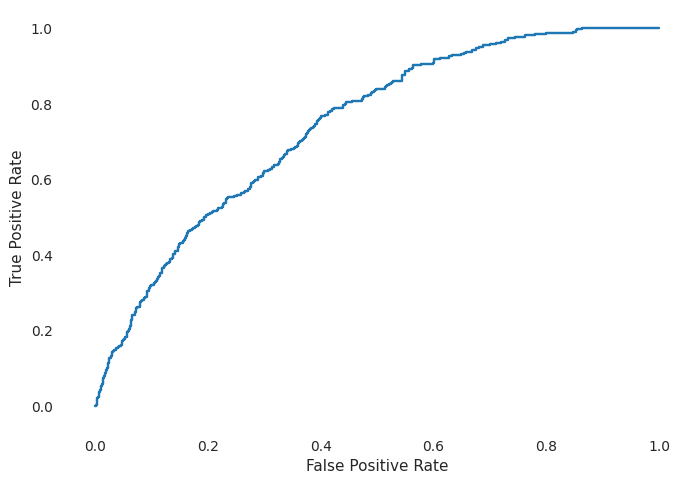

In [274]:
plt.plot(fpr4, tpr4)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [275]:
model1 = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    RandomForestClassifier(n_estimators=500, criterion='entropy', min_samples_leaf=2, 
                           random_state=23)
)

model1.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['Month', 'VisitorType'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='entropy',
                                        max_depth=None, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_impurity_split=None,
                                        min_samples_leaf=2, min_samples_split

In [276]:
print('Training Accuracy:', model1.score(X_train, y_train))
print('Validation Accuracy:', model1.score(X_val, y_val))

Training Accuracy: 0.9683698296836983
Validation Accuracy: 0.8499594484995945


In [277]:
model1_predict = model1.predict(X_val)
pd.crosstab(y_val, model1_predict)

col_0,False,True
Revenue,,
False,2059,25
True,345,37


In [278]:
print(classification_report(y_val, model1_predict))

              precision    recall  f1-score   support

       False       0.86      0.99      0.92      2084
        True       0.60      0.10      0.17       382

    accuracy                           0.85      2466
   macro avg       0.73      0.54      0.54      2466
weighted avg       0.82      0.85      0.80      2466



In [279]:
model1_pred_prob = model1.predict_proba(X_val)[:, -1]

fpr5, tpr5, thresholds5 = roc_curve(y_val, model1_pred_prob)

tpr_fpr_thresh5 = pd.DataFrame({'False Positive Rate': fpr5,
                    'True Positive Rate': tpr5,
                    'Threshold': np.round(thresholds5, 2)})
f = print('Random Forest Classifier without possible leakage:', roc_auc_score(y_val, model1_pred_prob))
tpr_fpr_thresh5

Random Forest Classifier without possible leakage: 0.783726170976073


,False Positive Rate,True Positive Rate,Threshold
0,0.000000,0.000000,1.73
1,0.000000,0.002618,0.73
2,0.000000,0.007853,0.71
3,0.000960,0.007853,0.66
4,0.000960,0.013089,0.64
...,...,...,...
582,0.966411,1.000000,0.00
583,0.966891,1.000000,0.00
584,0.968810,1.000000,0.00
585,0.969290,1.000000,0.00


Text(0, 0.5, 'True Positive Rate')

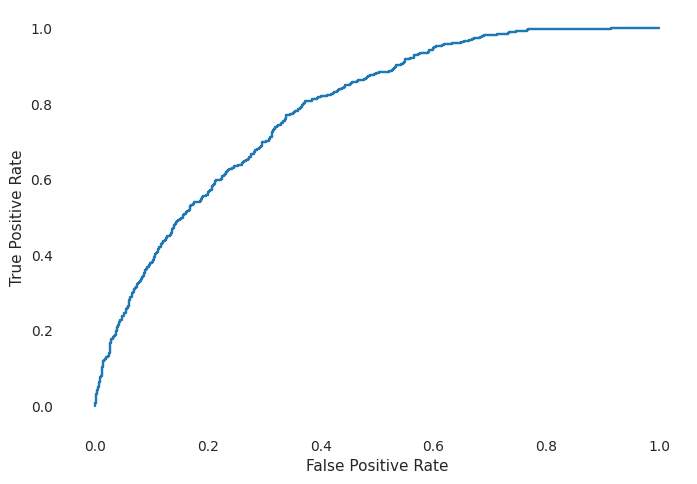

In [280]:
plt.plot(fpr5, tpr5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [281]:
print('Validation Accuracy of Logistic Regression after removing possible leakage:', log_model2.score(X_val, y_val))
print('Validation Accuracy of Random Forest Classifier after removing possible leakage:', model1.score(X_val, y_val))

Validation Accuracy of Logistic Regression after removing possible leakage: 0.8450932684509327
Validation Accuracy of Random Forest Classifier after removing possible leakage: 0.8499594484995945


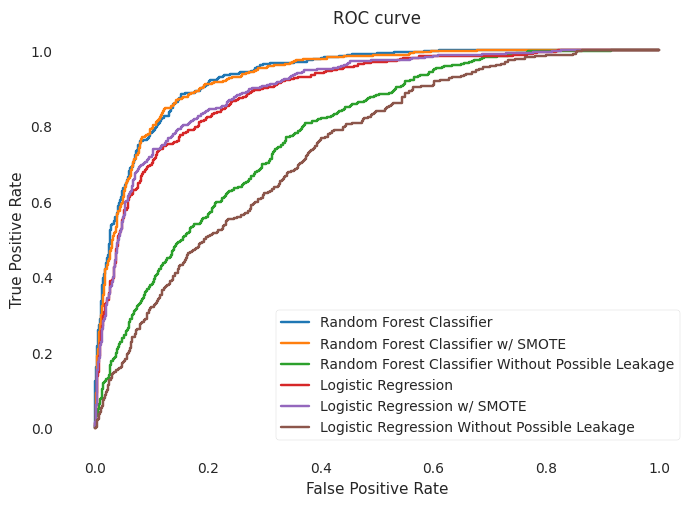

In [282]:
plt.plot(fpr, tpr, label='Random Forest Classifier')
plt.plot(fpr2, tpr2, label='Random Forest Classifier w/ SMOTE')
plt.plot(fpr5, tpr5, label='Random Forest Classifier Without Possible Leakage')
plt.plot(fpr3, tpr3, label = 'Logistic Regression')
plt.plot(fpr1, tpr1, label='Logistic Regression w/ SMOTE')
plt.plot(fpr4, tpr4, label='Logistic Regression Without Possible Leakage')
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate');

In [283]:
print('ROC_AUC scores:')
print('Logistic Regression without SMOTE:', roc_auc_score(y_val, log_pred_prob))
print('Logistic Regression with SMOTE:', roc_auc_score(y_val, y_pred_prob1))
print('Logistic Regression without possible leakage:', roc_auc_score(y_val, log_pred_prob2))
print('Random Forest Classifier without SMOTE:', roc_auc_score(y_val, y_pred_prob))
print('Random Forest Classifier with SMOTE:', roc_auc_score(y_val, y_pred_prob2))
print('Random Forest Classifier without possible leakage:', roc_auc_score(y_val, model1_pred_prob))

ROC_AUC scores:
Logistic Regression without SMOTE: 0.8956082744621199
Logistic Regression with SMOTE: 0.9016088673613972
Logistic Regression without possible leakage: 0.7421754881369899
Random Forest Classifier without SMOTE: 0.9335412667946257
Random Forest Classifier with SMOTE: 0.930428545587925
Random Forest Classifier without possible leakage: 0.783726170976073
